<h1 style="text-align: center; color: #E30613;"><b><i>Entraînement avec DziriBert sur les Données de Sentiments</i></b></h1>

<p style="font-size: 18px;">
Ce notebook présente un workflow complet pour l'entraînement et l'évaluation d'un modèle de classification des sentiments en utilisant <span style="color: #28A745;"><b>DziriBert</b></span>, un modèle de langage pré-entraîné. 
</p>

### <span style="color: #28A745;">**Objectifs :**</span>
1. Charger et prétraiter les données textuelles.
2. Encoder les étiquettes des sentiments.
3. Utiliser un tokenizer pour préparer les données pour le modèle.
4. Diviser les données en ensembles d'entraînement, de validation et de test.
5. Entraîner le modèle avec des techniques avancées comme le dropout et l'early stopping.
6. Évaluer les performances du modèle à l'aide de métriques comme la matrice de confusion et le rapport de classification.
7. Visualiser les courbes de pertes et d'accuracy pour analyser les performances.

### <span style="color: #28A745;">**Plan du Notebook :**</span>
1. **Introduction et Bibliothèques nécessaires**  
    Importation des bibliothèques et configuration de l'environnement.
    
2. **Chargement et Prétraitement des Données**  
    Nettoyage des données et préparation des étiquettes.

3. **Tokenization et Préparation des Données**  
    Utilisation du tokenizer DziriBert et création des ensembles d'entraînement, de validation et de test.

4. **Entraînement du Modèle**  
    Entraînement avec des techniques comme l'early stopping et le dropout.

5. **Évaluation et Visualisation**  
    Analyse des performances avec des métriques et des visualisations.

6. **Conclusion**  
    Résumé des résultats et perspectives d'amélioration.

# <span style="color: #E30613;">**DziriBert**</span>

## <span style="color: #28A745;">**Bibiliothèques nécessaires**</span>

In [ ]:
%pip install torch torchvision torchaudio scikit-learn matplotlib tqdm pandas

import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import functional as F
from torch import nn
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, get_scheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import random

## <span style="color: #28A745;">**Utilisation de GPU**</span>

In [ ]:
# ✅ Configuration du device GPU uniquement
assert torch.cuda.is_available(), "CUDA GPU is not available."
device = torch.device("cuda")

Device: cuda


## <span style="color: #28A745;">**Chargement des Données**</span>

In [ ]:
# 📁 Chargement des données
df = pd.read_csv("/content/Comments_clean.csv").dropna(subset=["Comments"])

## <span style="color: #28A745;">**Encodage des étiquettes**</span>

In [ ]:
# 🎯 Encodage des étiquettes
label_encoder = LabelEncoder()
df["Sentiments_encoded"] = label_encoder.fit_transform(df["Sentiments"])
num_labels = len(label_encoder.classes_)

## <span style="color: #28A745;">**Tokenizer, Split dataset (Train 70%, Test 20%, Val 10%)**</span>

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("alger-ia/dziribert")

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# ✂️ Split dataset (Train 70%, Test 20%, Val 10%)
dataset = SentimentDataset(df["Comments"].values, df["Sentiments_encoded"].values, tokenizer)
total_size = len(dataset)
train_size = int(0.7 * total_size)
test_size = int(0.2 * total_size)
val_size = total_size - train_size - test_size
train_set, test_set, val_set = random_split(dataset, [train_size, test_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)
test_loader = DataLoader(test_set, batch_size=16)

## <span style="color: #28A745;">**Chargement du modèle avec dropout custom**</span>

In [ ]:
# Chargement du modèle avec dropout custom
config = AutoConfig.from_pretrained("alger-ia/dziribert", num_labels=num_labels, hidden_dropout_prob=0.4)
model = AutoModelForSequenceClassification.from_pretrained("alger-ia/dziribert", config=config)
model.to(device)

## <span style="color: #28A745;">**Optimiseur et Scheduler**</span>

In [ ]:
# Optimiseur et Scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=num_training_steps)

## <span style="color: #28A745;">**Entraînement de Modèle**</span>

In [ ]:
# 🔧 Entraînement avec Early Stopping
best_val_loss = float("inf")
patience, patience_counter = 2, 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\\n🟢 Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"✅ Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/Results/best_model_DziriBert.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

## <span style="color: #28A745;">**Évaluation finale**</span>

In [ ]:
# Évaluation finale
model.load_state_dict(torch.load("/content/Results/best_model_DziriBert.pt"))
model.eval()
all_preds, all_labels = [], []

for batch in test_loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs.logits, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

print("\\n🔍 Rapport de classification pour DziriBert:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

## <span style="color: #28A745;">**Courbes des pertes**</span>

In [ ]:
# Courbes des pertes
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## <span style="color: #28A745;">**Matrice de confusion**</span>

In [ ]:
# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Reds")
plt.xlabel("P")
plt.ylabel("Prédictions")
plt.title("Matrice de confusion - DziriBert")
plt.show()

# DziriBert avec 90%

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


\n🟢 Epoch 1/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.54it/s]


✅ Train Loss: 0.9737 | Acc: 0.5275 - Val Loss: 0.6558 | Acc: 0.7466
\n🟢 Epoch 2/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


✅ Train Loss: 0.6005 | Acc: 0.7655 - Val Loss: 0.4254 | Acc: 0.8320
\n🟢 Epoch 3/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.45it/s]


✅ Train Loss: 0.4285 | Acc: 0.8387 - Val Loss: 0.3583 | Acc: 0.8623
\n🟢 Epoch 4/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


✅ Train Loss: 0.3596 | Acc: 0.8569 - Val Loss: 0.3440 | Acc: 0.8678
\n🟢 Epoch 5/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


✅ Train Loss: 0.3126 | Acc: 0.8837 - Val Loss: 0.3421 | Acc: 0.8733
\n🟢 Epoch 6/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


✅ Train Loss: 0.3031 | Acc: 0.8905 - Val Loss: 0.3418 | Acc: 0.8733
\n🟢 Epoch 7/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


✅ Train Loss: 0.2628 | Acc: 0.8948 - Val Loss: 0.3374 | Acc: 0.8760
\n🟢 Epoch 8/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.52it/s]


✅ Train Loss: 0.2429 | Acc: 0.9027 - Val Loss: 0.3387 | Acc: 0.8788
\n🟢 Epoch 9/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


✅ Train Loss: 0.2470 | Acc: 0.9051 - Val Loss: 0.3384 | Acc: 0.8815
⛔ Early stopping triggered.
\n🔍 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.90      0.86      0.88       160
      Neutre       0.85      0.87      0.86       244
     Positif       0.93      0.93      0.93       318

    accuracy                           0.90       722
   macro avg       0.89      0.89      0.89       722
weighted avg       0.90      0.90      0.90       722



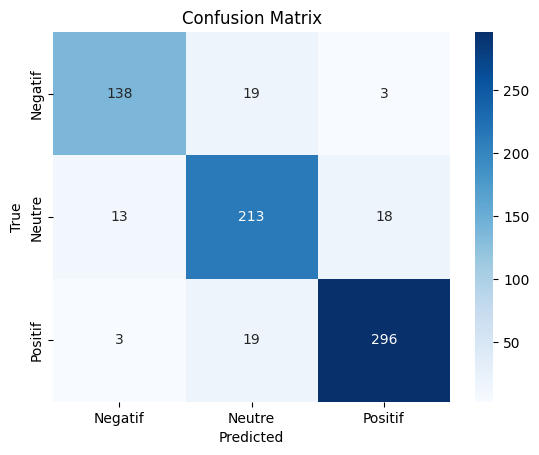

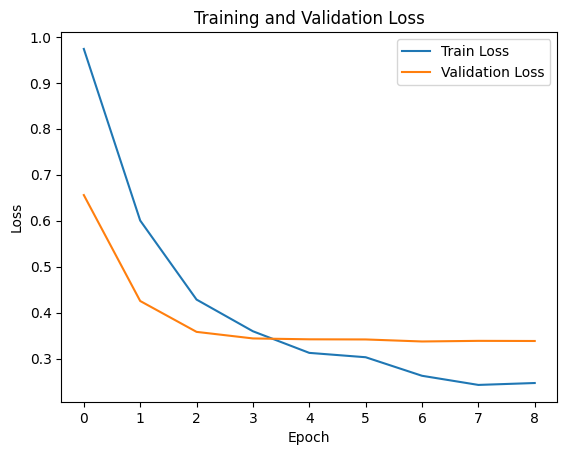

# DziriBert avec 89%

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


\n🟢 Epoch 1/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]


✅ Train Loss: 0.9573 | Acc: 0.5603 - Val Loss: 0.7013 | Acc: 0.7190
\n🟢 Epoch 2/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]


✅ Train Loss: 0.6316 | Acc: 0.7635 - Val Loss: 0.4802 | Acc: 0.8099
\n🟢 Epoch 3/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.84it/s]


✅ Train Loss: 0.4672 | Acc: 0.8296 - Val Loss: 0.3870 | Acc: 0.8485
\n🟢 Epoch 4/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.81it/s]


✅ Train Loss: 0.3693 | Acc: 0.8608 - Val Loss: 0.3527 | Acc: 0.8705
\n🟢 Epoch 5/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.74it/s]


✅ Train Loss: 0.3236 | Acc: 0.8849 - Val Loss: 0.3363 | Acc: 0.8733
\n🟢 Epoch 6/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.77it/s]


✅ Train Loss: 0.2804 | Acc: 0.8952 - Val Loss: 0.3329 | Acc: 0.8678
\n🟢 Epoch 7/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]


✅ Train Loss: 0.2713 | Acc: 0.8984 - Val Loss: 0.3291 | Acc: 0.8705
\n🟢 Epoch 8/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]


✅ Train Loss: 0.2501 | Acc: 0.9055 - Val Loss: 0.3280 | Acc: 0.8733
\n🟢 Epoch 9/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.75it/s]


✅ Train Loss: 0.2577 | Acc: 0.9106 - Val Loss: 0.3283 | Acc: 0.8788
\n🟢 Epoch 10/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.75it/s]


✅ Train Loss: 0.2405 | Acc: 0.9098 - Val Loss: 0.3282 | Acc: 0.8760
⛔ Early stopping triggered.
\n🔍 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.87      0.87      0.87       160
      Neutre       0.85      0.84      0.84       244
     Positif       0.92      0.93      0.92       318

    accuracy                           0.89       722
   macro avg       0.88      0.88      0.88       722
weighted avg       0.88      0.89      0.88       722



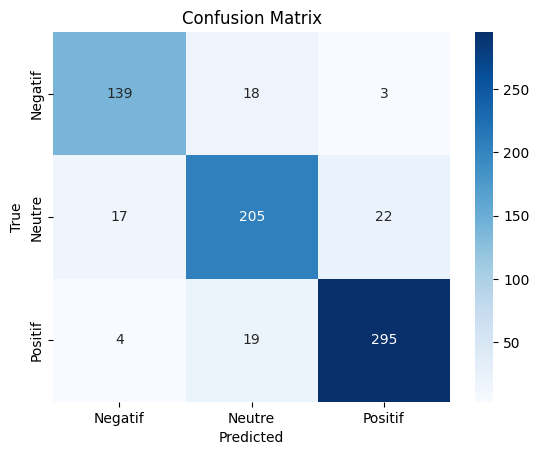

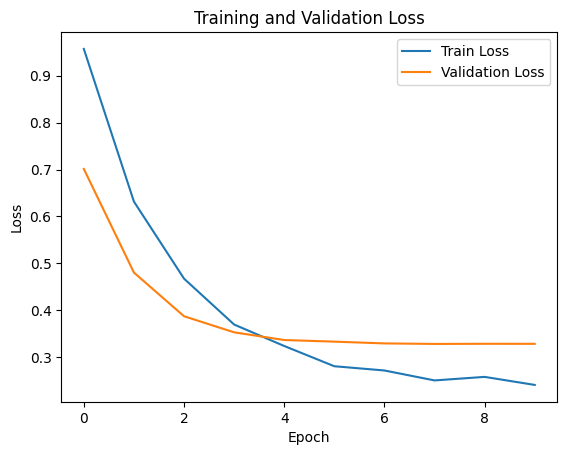

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import functional as F
from torch import nn
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, get_scheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import random

# Configuration du device GPU uniquement
assert torch.cuda.is_available(), "CUDA GPU is not available."
device = torch.device("cuda")

# 1. Chargement des données
df = pd.read_csv("/content/Comments_clean.csv").dropna(subset=["Comments"])

# 2. Encodage des sentiments
label_encoder = LabelEncoder()
df["Sentiments_encoded"] = label_encoder.fit_transform(df["Sentiments"])
num_labels = len(label_encoder.classes_)

# 3. Tokenizer et Dataset
tokenizer = AutoTokenizer.from_pretrained("alger-ia/dziribert")

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# 4. Split dataset (Train 70%, Test 20%, Val 10%)
dataset = SentimentDataset(df["Comments"].values, df["Sentiments_encoded"].values, tokenizer)
total_size = len(dataset)
train_size = int(0.7 * total_size)
test_size = int(0.2 * total_size)
val_size = total_size - train_size - test_size
train_set, test_set, val_set = random_split(dataset, [train_size, test_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)
test_loader = DataLoader(test_set, batch_size=16)

# 5. Chargement du modèle avec dropout custom
config = AutoConfig.from_pretrained("alger-ia/dziribert", num_labels=num_labels, hidden_dropout_prob=0.3)
model = AutoModelForSequenceClassification.from_pretrained("alger-ia/dziribert", config=config)
model.to(device)

# 6. Optimiseur et Scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01, eps=0.001)
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=num_training_steps)

# 7. Entraînement avec Early Stopping
best_val_loss = float("inf")
patience, patience_counter = 2, 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\\n🟢 Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"✅ Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

# 8. Évaluation finale
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
all_preds, all_labels = [], []

for batch in test_loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs.logits, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

print("\\n🔍 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# 9. Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 10. Courbes des pertes
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

---

# DziriBert avec 90%

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


\n🟢 Epoch 1/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  9.04it/s]


✅ Train Loss: 0.8639 | Acc: 0.5915 - Val Loss: 0.5430 | Acc: 0.7824
\n🟢 Epoch 2/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.66it/s]


✅ Train Loss: 0.4494 | Acc: 0.8193 - Val Loss: 0.3283 | Acc: 0.8650
\n🟢 Epoch 3/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.74it/s]


✅ Train Loss: 0.3176 | Acc: 0.8798 - Val Loss: 0.3295 | Acc: 0.8760
\n🟢 Epoch 4/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.82it/s]


✅ Train Loss: 0.2729 | Acc: 0.8940 - Val Loss: 0.3283 | Acc: 0.8898
\n🟢 Epoch 5/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.76it/s]


✅ Train Loss: 0.2241 | Acc: 0.9185 - Val Loss: 0.3181 | Acc: 0.8760
\n🟢 Epoch 6/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.75it/s]


✅ Train Loss: 0.2004 | Acc: 0.9296 - Val Loss: 0.3177 | Acc: 0.8788
\n🟢 Epoch 7/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.82it/s]


✅ Train Loss: 0.1733 | Acc: 0.9391 - Val Loss: 0.3068 | Acc: 0.8788
\n🟢 Epoch 8/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.77it/s]


✅ Train Loss: 0.1713 | Acc: 0.9348 - Val Loss: 0.3122 | Acc: 0.8926
\n🟢 Epoch 9/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.80it/s]


✅ Train Loss: 0.1577 | Acc: 0.9352 - Val Loss: 0.3122 | Acc: 0.8926
⛔ Early stopping triggered.
\n🔍 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.89      0.88      0.89       160
      Neutre       0.88      0.86      0.87       244
     Positif       0.92      0.94      0.93       318

    accuracy                           0.90       722
   macro avg       0.90      0.89      0.90       722
weighted avg       0.90      0.90      0.90       722



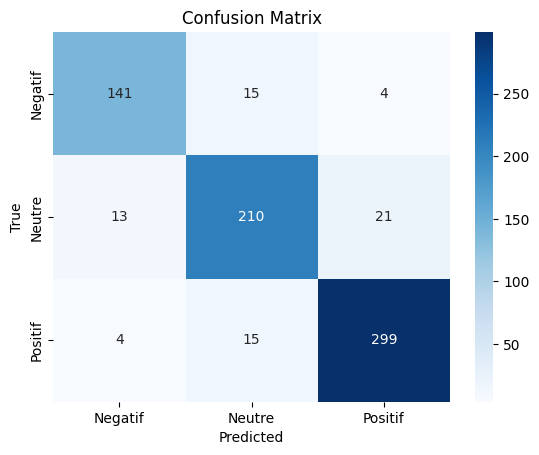

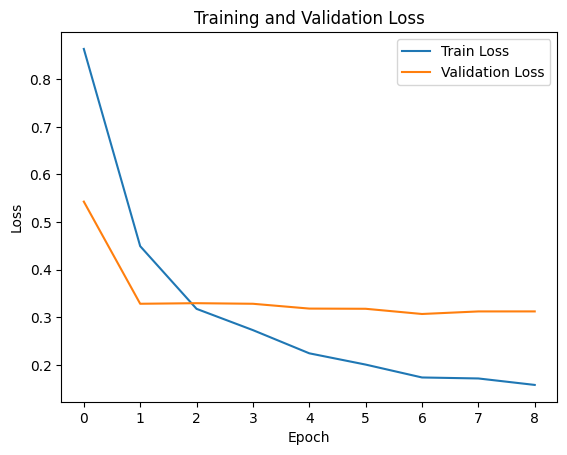

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import functional as F
from torch import nn
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, get_scheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import random

# Configuration du device GPU uniquement
assert torch.cuda.is_available(), "CUDA GPU is not available."
device = torch.device("cuda")

# 1. Chargement des données
df = pd.read_csv("/content/Comments_clean.csv").dropna(subset=["Comments"])

# 2. Encodage des sentiments
label_encoder = LabelEncoder()
df["Sentiments_encoded"] = label_encoder.fit_transform(df["Sentiments"])
num_labels = len(label_encoder.classes_)

# 3. Tokenizer et Dataset
tokenizer = AutoTokenizer.from_pretrained("alger-ia/dziribert")

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# 4. Split dataset (Train 70%, Test 20%, Val 10%)
dataset = SentimentDataset(df["Comments"].values, df["Sentiments_encoded"].values, tokenizer)
total_size = len(dataset)
train_size = int(0.7 * total_size)
test_size = int(0.2 * total_size)
val_size = total_size - train_size - test_size
train_set, test_set, val_set = random_split(dataset, [train_size, test_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)
test_loader = DataLoader(test_set, batch_size=16)

# 5. Chargement du modèle avec dropout custom
config = AutoConfig.from_pretrained("alger-ia/dziribert", num_labels=num_labels, hidden_dropout_prob=0.4)
model = AutoModelForSequenceClassification.from_pretrained("alger-ia/dziribert", config=config)
model.to(device)

# 6. Optimiseur et Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, eps=0.0001)
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=75, num_training_steps=num_training_steps)

# 7. Entraînement avec Early Stopping
best_val_loss = float("inf")
patience, patience_counter = 2, 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\\n🟢 Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"✅ Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

# 8. Évaluation finale
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
all_preds, all_labels = [], []

for batch in test_loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs.logits, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

print("\\n🔍 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# 9. Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 10. Courbes des pertes
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

----

# DziriBert avec StratifiedKFold et avec 88%


🔁 Fold 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📚 Epoch 1/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  9.17it/s]


✅ Train Loss: 0.8976, Acc: 0.5588 | Val Loss: 0.4596, Acc: 0.8256

📚 Epoch 2/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.81it/s]


✅ Train Loss: 0.4463, Acc: 0.8205 | Val Loss: 0.3305, Acc: 0.8549

📚 Epoch 3/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.99it/s]


✅ Train Loss: 0.3142, Acc: 0.8845 | Val Loss: 0.3113, Acc: 0.8877

📚 Epoch 4/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.93it/s]


✅ Train Loss: 0.2518, Acc: 0.9014 | Val Loss: 0.2911, Acc: 0.8860

📚 Epoch 5/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  9.00it/s]


✅ Train Loss: 0.2327, Acc: 0.9196 | Val Loss: 0.2935, Acc: 0.8998

📚 Epoch 6/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.94it/s]


✅ Train Loss: 0.2077, Acc: 0.9239 | Val Loss: 0.3058, Acc: 0.8981
⛔ Early stopping.

📊 Rapport du Fold:
              precision    recall  f1-score   support

     Negatif       0.91      0.88      0.90       138
      Neutre       0.83      0.87      0.85       189
     Positif       0.94      0.92      0.93       252

    accuracy                           0.90       579
   macro avg       0.90      0.89      0.89       579
weighted avg       0.90      0.90      0.90       579


🔁 Fold 2/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📚 Epoch 1/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.98it/s]


✅ Train Loss: 0.8501, Acc: 0.5888 | Val Loss: 0.4372, Acc: 0.8495

📚 Epoch 2/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.97it/s]


✅ Train Loss: 0.4325, Acc: 0.8210 | Val Loss: 0.3252, Acc: 0.8789

📚 Epoch 3/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.95it/s]


✅ Train Loss: 0.3048, Acc: 0.8880 | Val Loss: 0.3089, Acc: 0.8997

📚 Epoch 4/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.95it/s]


✅ Train Loss: 0.2637, Acc: 0.9010 | Val Loss: 0.2905, Acc: 0.9066

📚 Epoch 5/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  9.02it/s]


✅ Train Loss: 0.2092, Acc: 0.9261 | Val Loss: 0.3144, Acc: 0.8962

📚 Epoch 6/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.92it/s]


✅ Train Loss: 0.1947, Acc: 0.9261 | Val Loss: 0.3013, Acc: 0.9066
⛔ Early stopping.

📊 Rapport du Fold:
              precision    recall  f1-score   support

     Negatif       0.90      0.92      0.91       138
      Neutre       0.87      0.87      0.87       189
     Positif       0.94      0.92      0.93       251

    accuracy                           0.91       578
   macro avg       0.90      0.91      0.90       578
weighted avg       0.91      0.91      0.91       578


🔁 Fold 3/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📚 Epoch 1/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  9.00it/s]


✅ Train Loss: 0.8867, Acc: 0.5629 | Val Loss: 0.4298, Acc: 0.8374

📚 Epoch 2/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.95it/s]


✅ Train Loss: 0.4654, Acc: 0.8171 | Val Loss: 0.2934, Acc: 0.8772

📚 Epoch 3/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  9.02it/s]


✅ Train Loss: 0.3332, Acc: 0.8746 | Val Loss: 0.2784, Acc: 0.8997

📚 Epoch 4/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.95it/s]


✅ Train Loss: 0.2724, Acc: 0.9049 | Val Loss: 0.2434, Acc: 0.9066

📚 Epoch 5/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  9.01it/s]


✅ Train Loss: 0.2304, Acc: 0.9187 | Val Loss: 0.2487, Acc: 0.9100

📚 Epoch 6/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.98it/s]


✅ Train Loss: 0.2136, Acc: 0.9252 | Val Loss: 0.2412, Acc: 0.9100

📚 Epoch 7/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.97it/s]


✅ Train Loss: 0.1758, Acc: 0.9399 | Val Loss: 0.2482, Acc: 0.9187

📚 Epoch 8/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.98it/s]


✅ Train Loss: 0.1632, Acc: 0.9429 | Val Loss: 0.2522, Acc: 0.9187
⛔ Early stopping.

📊 Rapport du Fold:
              precision    recall  f1-score   support

     Negatif       0.91      0.91      0.91       138
      Neutre       0.90      0.88      0.89       188
     Positif       0.94      0.96      0.95       252

    accuracy                           0.92       578
   macro avg       0.91      0.91      0.91       578
weighted avg       0.92      0.92      0.92       578


🔁 Fold 4/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📚 Epoch 1/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.98it/s]


✅ Train Loss: 0.8583, Acc: 0.6074 | Val Loss: 0.4396, Acc: 0.8045

📚 Epoch 2/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  9.04it/s]


✅ Train Loss: 0.4556, Acc: 0.8219 | Val Loss: 0.3277, Acc: 0.8789

📚 Epoch 3/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  9.00it/s]


✅ Train Loss: 0.3398, Acc: 0.8725 | Val Loss: 0.2726, Acc: 0.8979

📚 Epoch 4/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  9.03it/s]


✅ Train Loss: 0.2794, Acc: 0.8941 | Val Loss: 0.2864, Acc: 0.8962

📚 Epoch 5/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  9.03it/s]


✅ Train Loss: 0.2474, Acc: 0.9092 | Val Loss: 0.2608, Acc: 0.8997

📚 Epoch 6/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  9.04it/s]


✅ Train Loss: 0.2121, Acc: 0.9200 | Val Loss: 0.2777, Acc: 0.9066

📚 Epoch 7/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  9.00it/s]


✅ Train Loss: 0.1921, Acc: 0.9347 | Val Loss: 0.2852, Acc: 0.9048
⛔ Early stopping.

📊 Rapport du Fold:
              precision    recall  f1-score   support

     Negatif       0.83      0.87      0.85       138
      Neutre       0.86      0.85      0.86       188
     Positif       0.98      0.96      0.97       252

    accuracy                           0.90       578
   macro avg       0.89      0.89      0.89       578
weighted avg       0.91      0.90      0.91       578


🔁 Fold 5/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📚 Epoch 1/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.99it/s]


✅ Train Loss: 0.8545, Acc: 0.6001 | Val Loss: 0.4585, Acc: 0.8201

📚 Epoch 2/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.96it/s]


✅ Train Loss: 0.4366, Acc: 0.8262 | Val Loss: 0.3175, Acc: 0.8893

📚 Epoch 3/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.98it/s]


✅ Train Loss: 0.3049, Acc: 0.8876 | Val Loss: 0.3230, Acc: 0.8945

📚 Epoch 4/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.94it/s]


✅ Train Loss: 0.2557, Acc: 0.9101 | Val Loss: 0.3011, Acc: 0.9031

📚 Epoch 5/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  9.07it/s]


✅ Train Loss: 0.2182, Acc: 0.9170 | Val Loss: 0.3254, Acc: 0.8997

📚 Epoch 6/10


Validation: 100%|██████████| 37/37 [00:04<00:00,  8.31it/s]


✅ Train Loss: 0.1773, Acc: 0.9356 | Val Loss: 0.3095, Acc: 0.9152
⛔ Early stopping.

📊 Rapport du Fold:
              precision    recall  f1-score   support

     Negatif       0.90      0.91      0.90       138
      Neutre       0.87      0.89      0.88       188
     Positif       0.96      0.94      0.95       252

    accuracy                           0.92       578
   macro avg       0.91      0.91      0.91       578
weighted avg       0.92      0.92      0.92       578


📈 Rapport Global (Validation) :
              precision    recall  f1-score   support

     Negatif       0.89      0.90      0.89       690
      Neutre       0.87      0.87      0.87       942
     Positif       0.95      0.94      0.95      1259

    accuracy                           0.91      2891
   macro avg       0.90      0.90      0.90      2891
weighted avg       0.91      0.91      0.91      2891



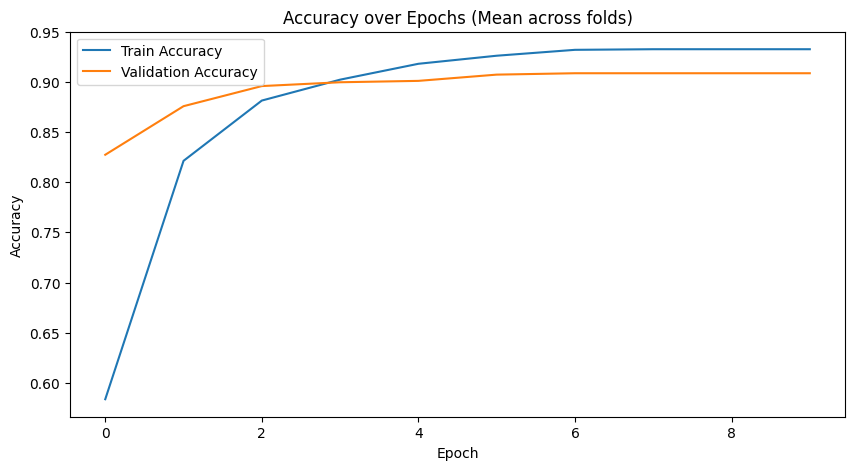

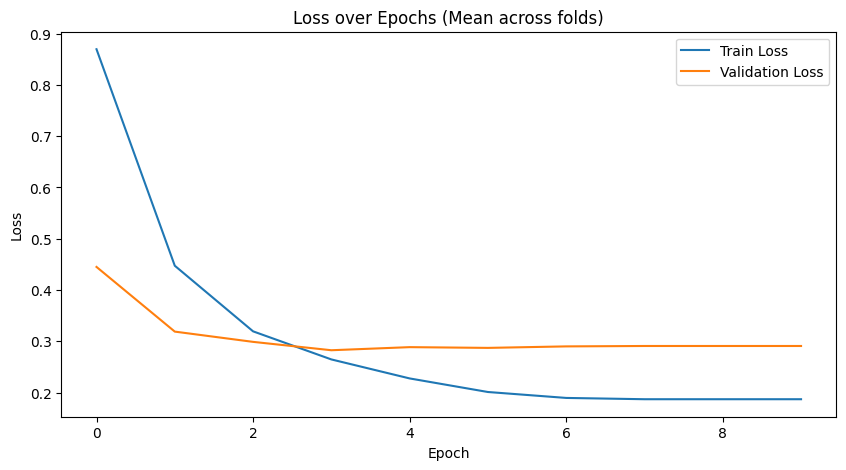

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🧪 Évaluation finale sur le jeu de test


Test: 100%|██████████| 46/46 [00:05<00:00,  8.78it/s]



📋 Rapport de classification (Test Set) :
              precision    recall  f1-score   support

     Negatif       0.90      0.87      0.88       172
      Neutre       0.81      0.85      0.83       236
     Positif       0.93      0.91      0.92       315

    accuracy                           0.88       723
   macro avg       0.88      0.88      0.88       723
weighted avg       0.88      0.88      0.88       723



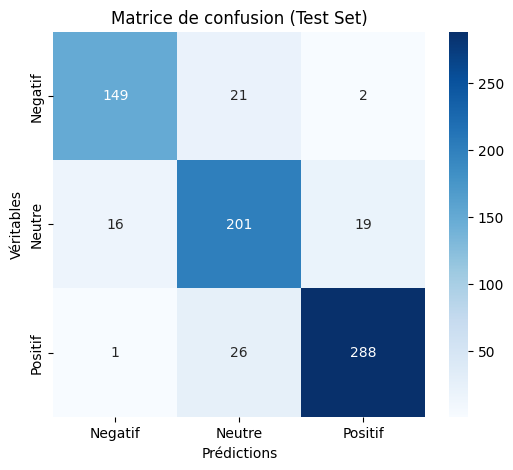

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from torch.nn import functional as F
from torch import nn
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, get_scheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import random

# Configuration
assert torch.cuda.is_available(), "CUDA GPU is not available."
device = torch.device("cuda")

# Chargement des données
df = pd.read_csv("/content/Comments_clean.csv").dropna(subset=["Comments"])
label_encoder = LabelEncoder()
df["Sentiments_encoded"] = label_encoder.fit_transform(df["Sentiments"])
num_labels = len(label_encoder.classes_)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("alger-ia/dziribert")

# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Séparation en train+val / test
X = df["Comments"].values
y = df["Sentiments_encoded"].values
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
temp_df = pd.DataFrame({'Comments': X_temp, 'Sentiments_encoded': y_temp})
test_df = pd.DataFrame({'Comments': X_test, 'Sentiments_encoded': y_test})

# K-Fold Cross-Validation sur les 80% d'entraînement
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

all_train_accs, all_val_accs = [], []
all_train_losses, all_val_losses = [], []
all_preds, all_true = [], []
best_model_state = None

for fold, (train_idx, val_idx) in enumerate(skf.split(X_temp, y_temp)):
    print(f"\n🔁 Fold {fold+1}/{n_splits}")

    fold_dataset = SentimentDataset(temp_df["Comments"].values, temp_df["Sentiments_encoded"].values, tokenizer)
    train_subset = Subset(fold_dataset, train_idx)
    val_subset = Subset(fold_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=16)

    config = AutoConfig.from_pretrained("alger-ia/dziribert", num_labels=num_labels, hidden_dropout_prob=0.4)
    model = AutoModelForSequenceClassification.from_pretrained("alger-ia/dziribert", config=config).to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=75,
                                 num_training_steps=len(train_loader)*10)

    best_val_loss = float("inf")
    patience = 2
    counter = 0

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(10):
        print(f"\n📚 Epoch {epoch+1}/10")

        # Training
        model.train()
        total_loss, correct, total = 0, 0, 0
        for batch in tqdm(train_loader, desc="Training"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_losses.append(total_loss / len(train_loader))
        train_accs.append(correct / total)

        # Validation
        model.eval()
        total_val_loss, correct, total = 0, 0, 0
        fold_preds, fold_labels = [], []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                total_val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                fold_preds.extend(preds.cpu().numpy())
                fold_labels.extend(labels.cpu().numpy())

        val_losses.append(total_val_loss / len(val_loader))
        val_accs.append(correct / total)

        print(f"✅ Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}, Acc: {val_accs[-1]:.4f}")

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("⛔ Early stopping.")
                break

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accs.append(train_accs)
    all_val_accs.append(val_accs)

    all_preds.extend(fold_preds)
    all_true.extend(fold_labels)

    print("\n📊 Rapport du Fold:")
    print(classification_report(fold_labels, fold_preds, target_names=label_encoder.classes_))

# Global classification report (validation only)
print("\n📈 Rapport Global (Validation) :")
print(classification_report(all_true, all_preds, target_names=label_encoder.classes_))

# Courbes globales
mean_train_acc = np.mean([np.pad(acc, (0, 10 - len(acc)), 'edge') for acc in all_train_accs], axis=0)
mean_val_acc = np.mean([np.pad(acc, (0, 10 - len(acc)), 'edge') for acc in all_val_accs], axis=0)
mean_train_loss = np.mean([np.pad(loss, (0, 10 - len(loss)), 'edge') for loss in all_train_losses], axis=0)
mean_val_loss = np.mean([np.pad(loss, (0, 10 - len(loss)), 'edge') for loss in all_val_losses], axis=0)

plt.figure(figsize=(10,5))
plt.plot(mean_train_acc, label="Train Accuracy")
plt.plot(mean_val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs (Mean across folds)")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(mean_train_loss, label="Train Loss")
plt.plot(mean_val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs (Mean across folds)")
plt.legend()
plt.show()

# 🧪 Évaluation finale sur le jeu de test
print("\n🧪 Évaluation finale sur le jeu de test")

test_dataset = SentimentDataset(test_df["Comments"].values, test_df["Sentiments_encoded"].values, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16)

final_model = AutoModelForSequenceClassification.from_pretrained("alger-ia/dziribert", config=config).to(device)
final_model.load_state_dict(best_model_state)
final_model.eval()

test_preds, test_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = final_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Rapport de classification et matrice de confusion (Test)
print("\n📋 Rapport de classification (Test Set) :")
print(classification_report(test_labels, test_preds, target_names=label_encoder.classes_))

conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Matrice de confusion (Test Set)")
plt.xlabel("Prédictions")
plt.ylabel("Véritables")
plt.show()

# Pas en cours...

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from torch.nn import functional as F
from torch import nn
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, get_scheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import random

# Configuration
assert torch.cuda.is_available(), "CUDA GPU is not available."
device = torch.device("cuda")

# Chargement des données
df = pd.read_csv("/content/Comments_clean.csv").dropna(subset=["Comments"])
label_encoder = LabelEncoder()
df["Sentiments_encoded"] = label_encoder.fit_transform(df["Sentiments"])
num_labels = len(label_encoder.classes_)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("alger-ia/dziribert")

# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Séparation en train+val / test
X = df["Comments"].values
y = df["Sentiments_encoded"].values
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
temp_df = pd.DataFrame({'Comments': X_temp, 'Sentiments_encoded': y_temp})
test_df = pd.DataFrame({'Comments': X_test, 'Sentiments_encoded': y_test})

# K-Fold Cross-Validation sur les 80% d'entraînement
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

all_train_accs, all_val_accs = [], []
all_train_losses, all_val_losses = [], []
all_preds, all_true = [], []
best_model_state = None

for fold, (train_idx, val_idx) in enumerate(skf.split(X_temp, y_temp)):
    print(f"\n🔁 Fold {fold+1}/{n_splits}")

    fold_dataset = SentimentDataset(temp_df["Comments"].values, temp_df["Sentiments_encoded"].values, tokenizer)
    train_subset = Subset(fold_dataset, train_idx)
    val_subset = Subset(fold_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=128)

    config = AutoConfig.from_pretrained("alger-ia/dziribert", num_labels=num_labels, hidden_dropout_prob=0.4)
    model = AutoModelForSequenceClassification.from_pretrained("alger-ia/dziribert", config=config).to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, eps=0.0001)
    lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=75,
                                 num_training_steps=len(train_loader)*10)

    best_val_loss = float("inf")
    patience = 2
    counter = 0

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(20):
        print(f"\n📚 Epoch {epoch+1}/20")

        # Training
        model.train()
        total_loss, correct, total = 0, 0, 0
        for batch in tqdm(train_loader, desc="Training"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_losses.append(total_loss / len(train_loader))
        train_accs.append(correct / total)

        # Validation
        model.eval()
        total_val_loss, correct, total = 0, 0, 0
        fold_preds, fold_labels = [], []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                total_val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                fold_preds.extend(preds.cpu().numpy())
                fold_labels.extend(labels.cpu().numpy())

        val_losses.append(total_val_loss / len(val_loader))
        val_accs.append(correct / total)

        print(f"✅ Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}, Acc: {val_accs[-1]:.4f}")

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("⛔ Early stopping.")
                break

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accs.append(train_accs)
    all_val_accs.append(val_accs)

    all_preds.extend(fold_preds)
    all_true.extend(fold_labels)

    print("\n📊 Rapport du Fold:")
    print(classification_report(fold_labels, fold_preds, target_names=label_encoder.classes_))

# Global classification report (validation only)
print("\n📈 Rapport Global (Validation) :")
print(classification_report(all_true, all_preds, target_names=label_encoder.classes_))

# Courbes globales
mean_train_acc = np.mean([np.pad(acc, (0, 10 - len(acc)), 'edge') for acc in all_train_accs], axis=0)
mean_val_acc = np.mean([np.pad(acc, (0, 10 - len(acc)), 'edge') for acc in all_val_accs], axis=0)
mean_train_loss = np.mean([np.pad(loss, (0, 10 - len(loss)), 'edge') for loss in all_train_losses], axis=0)
mean_val_loss = np.mean([np.pad(loss, (0, 10 - len(loss)), 'edge') for loss in all_val_losses], axis=0)

plt.figure(figsize=(10,5))
plt.plot(mean_train_acc, label="Train Accuracy")
plt.plot(mean_val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs (Mean across folds)")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(mean_train_loss, label="Train Loss")
plt.plot(mean_val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs (Mean across folds)")
plt.legend()
plt.show()

# 🧪 Évaluation finale sur le jeu de test
print("\n🧪 Évaluation finale sur le jeu de test")

test_dataset = SentimentDataset(test_df["Comments"].values, test_df["Sentiments_encoded"].values, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=128)

final_model = AutoModelForSequenceClassification.from_pretrained("alger-ia/dziribert", config=config).to(device)
final_model.load_state_dict(best_model_state)
final_model.eval()

test_preds, test_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = final_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Rapport de classification et matrice de confusion (Test)
print("\n📋 Rapport de classification (Test Set) :")
print(classification_report(test_labels, test_preds, target_names=label_encoder.classes_))

conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Matrice de confusion (Test Set)")
plt.xlabel("Prédictions")
plt.ylabel("Véritables")
plt.show()


🔁 Fold 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📚 Epoch 1/20


Training:   0%|          | 0/19 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 42.12 MiB is free. Process 2942 has 14.70 GiB memory in use. Of the allocated memory 13.73 GiB is allocated by PyTorch, and 855.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

<h3 style="text-align: center; color: #E30613;"><b><i>Développé par: OUARAS Khelil Rafik</i></b></h3>